In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

import LearningCutsUtils.LearningCutsUtils
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork

In [2]:
import importlib
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)

<module 'LearningCutsUtils.LearningCutsUtils' from '/home/mhance/mhance/docs/teaching/2024_Fall_115/NN-For-Cuts/LearningCutsUtils/LearningCutsUtils.py'>

Now let's generate two histograms and play around with separating them.

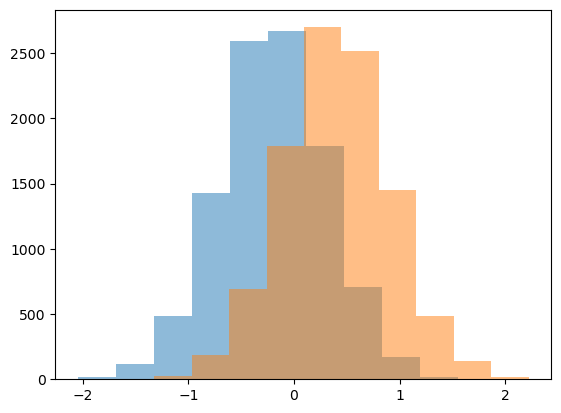

In [3]:
N=10000
x_signal=-0.2+0.5*np.random.randn(N)
y_signal=np.ones(N)
x_backgr=0.4+0.5*np.random.randn(N)
y_backgr=np.zeros(N)
plt.hist(x_signal,alpha=0.5)
plt.hist(x_backgr,alpha=0.5)
plt.show()
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [5]:
sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train.reshape(-1, 1))
x_test_scaled  = sc.transform(x_test.reshape(-1, 1))

In [6]:
features=1

torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(features, features)
)
#net[0].weight[0][1] = torch.nn.Parameter(torch.tensor([1.]), requires_grad=False)
#print(net[0].weight)
torch.save(net.state_dict(), 'net.pth')

bce_loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
y_train_tensor=y_train_tensor.unsqueeze(1)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
y_test_tensor=y_test_tensor.unsqueeze(1)

In [8]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
    # we need to send the network and data to the GPU!
    net.to(device)
    x_train_tensor=x_train_tensor.to(device)
    y_train_tensor=y_train_tensor.to(device)
    x_test_tensor=x_test_tensor.to(device)
    y_test_tensor=y_test_tensor.to(device)

    
xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(y_train)/1), shuffle=True)


for epoch in range(50):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        #print(net[0].bias)
        #print(net[0].weight)
        y_pred = net(x_batch)
        #print(y_pred)
        optimizer.zero_grad()
        loss = bce_loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=bce_loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.3s, Train loss=6.1e-01, Test loss=6.0e-01
Completed epoch  1 in  0.4s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch  2 in  0.2s, Train loss=5.9e-01, Test loss=5.8e-01
Completed epoch  3 in  0.4s, Train loss=5.9e-01, Test loss=5.8e-01
Completed epoch  4 in  0.2s, Train loss=5.8e-01, Test loss=5.7e-01
Completed epoch  5 in  0.4s, Train loss=5.8e-01, Test loss=5.7e-01
Completed epoch  6 in  0.2s, Train loss=5.7e-01, Test loss=5.6e-01
Completed epoch  7 in  0.3s, Train loss=5.7e-01, Test loss=5.6e-01
Completed epoch  8 in  0.2s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch  9 in  0.3s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch 10 in  0.2s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch 11 in  0.4s, Train loss=5.5e-01, Test loss=5.4e-01
Completed epoch 12 in  0.2s, Train loss=5.5e-01, Test loss=5.4e-01
Completed epoch 13 in  0.2s, Train loss=5.5e-01, Test loss=5.4e-01
Completed epoch 14 in  0.4s, Train loss=5.5e-01, Test loss=5.4

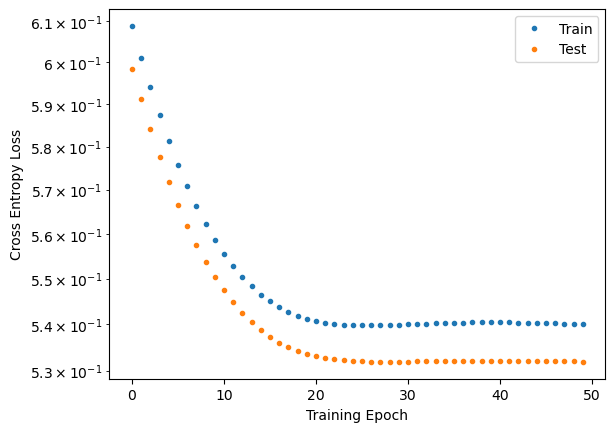

In [9]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In [10]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.sigmoid(net(x_test_tensor)).detach().cpu()
y_pred_train= torch.sigmoid(net(x_train_tensor)).detach().cpu()

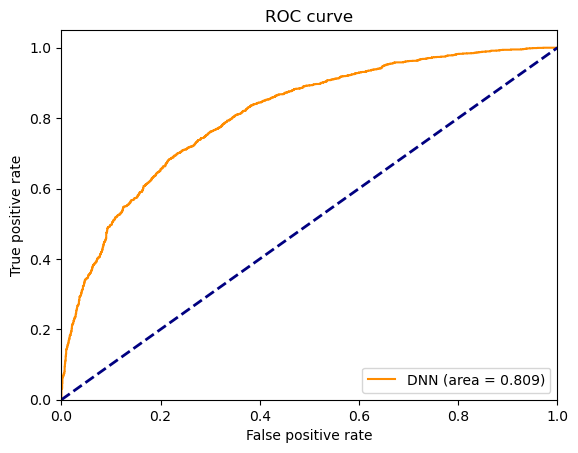

In [11]:
LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test,y_pred_test)

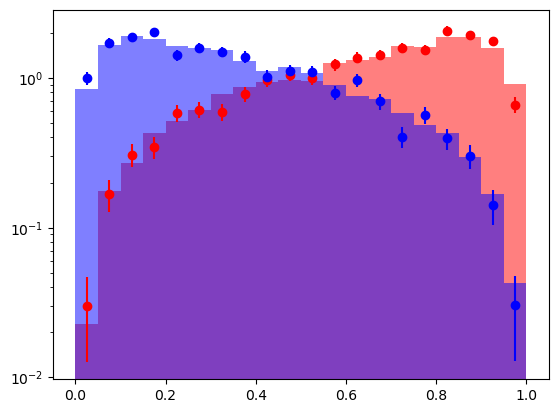

In [12]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

In [13]:
bias=net[0].bias.detach()[0]
weight=net[0].weight.detach()[0][0]
print(bias)
print(weight)
sc.inverse_transform([[-1.*bias/weight]])

tensor(-0.0021)
tensor(-1.4787)


array([[0.1012051]])

The calculation above yields the optimal cut value in the un-transformed feature space.

It looks, though, like we can only either fix or not-fix the entire weight matrix, so it won't be easy to use Linear layers to train selection against multiple features.  We'll have to implement as a series of 1D transforms, and then check BCE (or equivalent) on the sum.

# Now in more dimensions

In [14]:
N=20000 # number of points
m=10 # dimensions

In [15]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)
means_widths=np.random.randn(m,2,2)
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

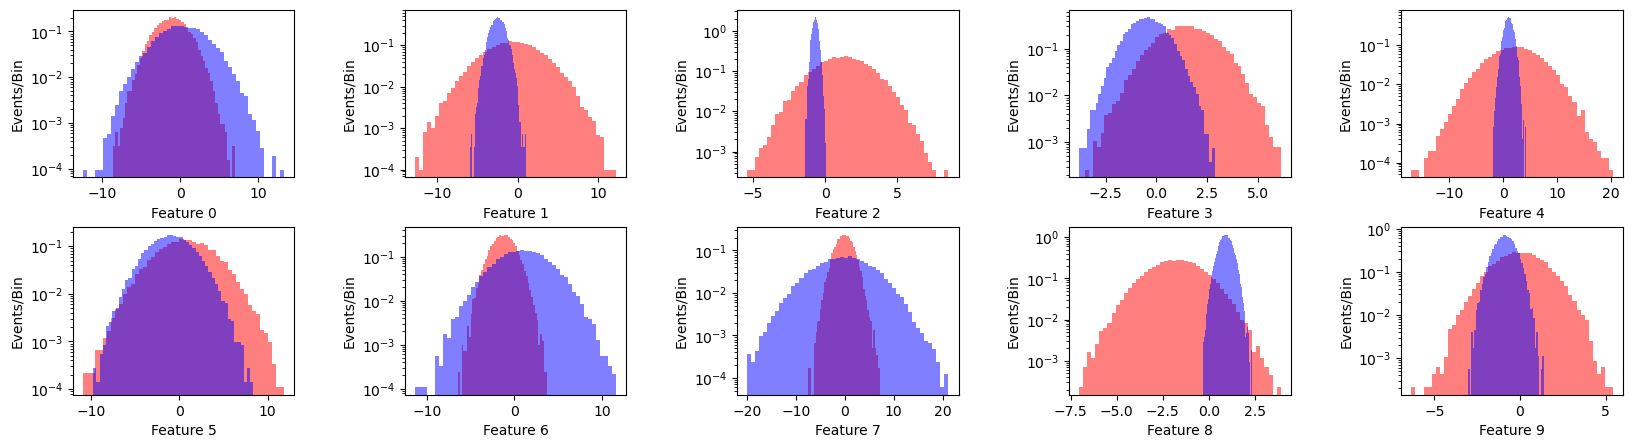

In [16]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [18]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

For this kind of network, need the 
* inputs to be our matrix of N rows (events) and m columns (features)
* weights and biases, with some shape that enables the output to be:
* outputs that give the distance of each feature from the correct classification

Ideally will have expressions like (this is not real matrix algebra, unfortunately, but if only we could cheat):

$$
\begin{bmatrix}
x_{1}\\
...\\
x_{m}
\end{bmatrix}
\begin{bmatrix}
w_{1} & ... & w_{m}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
y_{1} & ... &y_{m}
\end{bmatrix}
$$

For a large group of events:

$$
\begin{bmatrix}
w_{1}\\
...\\
w_{m}
\end{bmatrix}
\begin{bmatrix}
x_{11} & ... & x_{1m}\\
... & ... & ...\\
x_{N1} & ... & x_{Nm}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
(w_{1}x_{11}+b_{1}) & ... &(w_{m}x_{1m}+b_{m})\\
... & ... & ...\\
(w_{1}x_{N1}+b_{1}) & ... &(w_{m}x_{Nm}+b_{m})
\end{bmatrix}
=
\begin{bmatrix}
y_{11} & ... &y_{1m}\\
... & ... & ...\\
y_{N1} & ... &y_{Nm}
\end{bmatrix}
$$

Then we need a way to calculate a single "score" based on the $y$ values for a given event.  Could be some distance in the $m$-dimensional feature space (1-norm or 2-norm), or just whether it failed a single cut or not, etc.

In [19]:
torch.manual_seed(123)
net=OneToOneLinear(m,2)

torch.save(net.state_dict(), 'net_learningcuts_1.pth')


bce_loss_fn = torch.nn.BCELoss()
def loss_fn (y_pred, y_true, features):
    return bce_loss_fn(LearningCutsUtils.LearningCutsUtils.outputs_to_labels(y_pred,features),y_true)

In [20]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
batch_size=int(len(y_train)/1) # one batch
epochs=50

In [21]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningcuts_1.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor, m)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  1.0s, Train loss=6.6e-01, Test loss=5.3e-01
Completed epoch  1 in  0.9s, Train loss=5.3e-01, Test loss=4.4e-01
Completed epoch  2 in  0.6s, Train loss=4.4e-01, Test loss=4.0e-01
Completed epoch  3 in  0.7s, Train loss=4.0e-01, Test loss=3.7e-01
Completed epoch  4 in  0.7s, Train loss=3.7e-01, Test loss=3.5e-01
Completed epoch  5 in  0.8s, Train loss=3.5e-01, Test loss=3.5e-01
Completed epoch  6 in  0.5s, Train loss=3.4e-01, Test loss=3.4e-01
Completed epoch  7 in  0.7s, Train loss=3.4e-01, Test loss=3.3e-01
Completed epoch  8 in  0.7s, Train loss=3.3e-01, Test loss=3.3e-01
Completed epoch  9 in  0.7s, Train loss=3.3e-01, Test loss=3.3e-01
Completed epoch 10 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 11 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 12 in  0.5s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 13 in  0.6s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 14 in  0.7s, Train loss=3.2e-01, Test loss=3.2

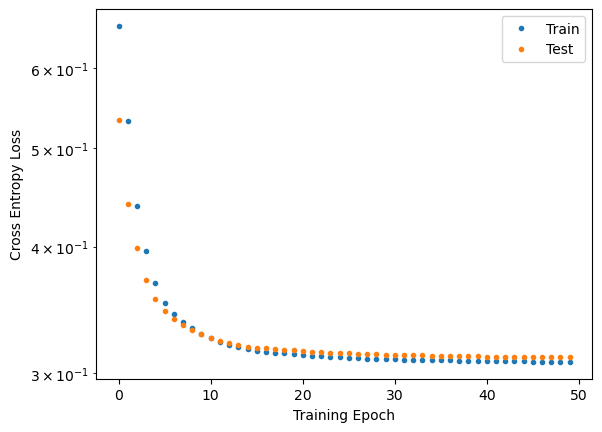

In [22]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

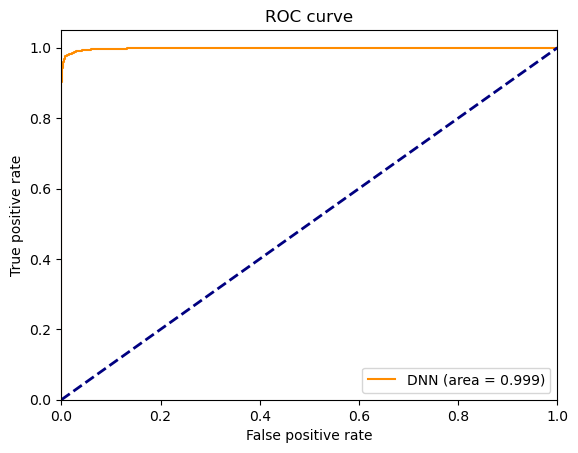

In [23]:
net.eval() # configure the model for evaluation (testing)
from LearningCutsUtils.LearningCutsUtils import outputs_to_labels as outputs_to_labels
y_pred_test = outputs_to_labels(net(x_test_tensor),m).detach().cpu()
y_pred_train= outputs_to_labels(net(x_train_tensor),m).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

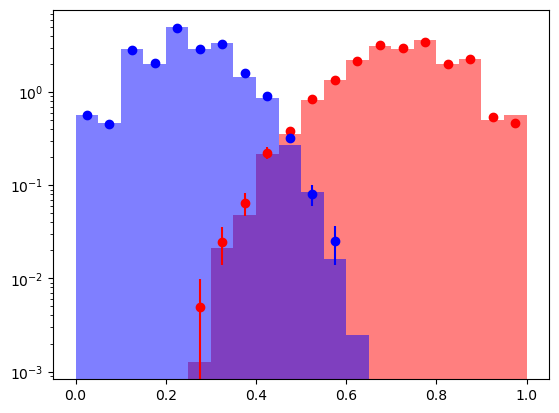

In [24]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

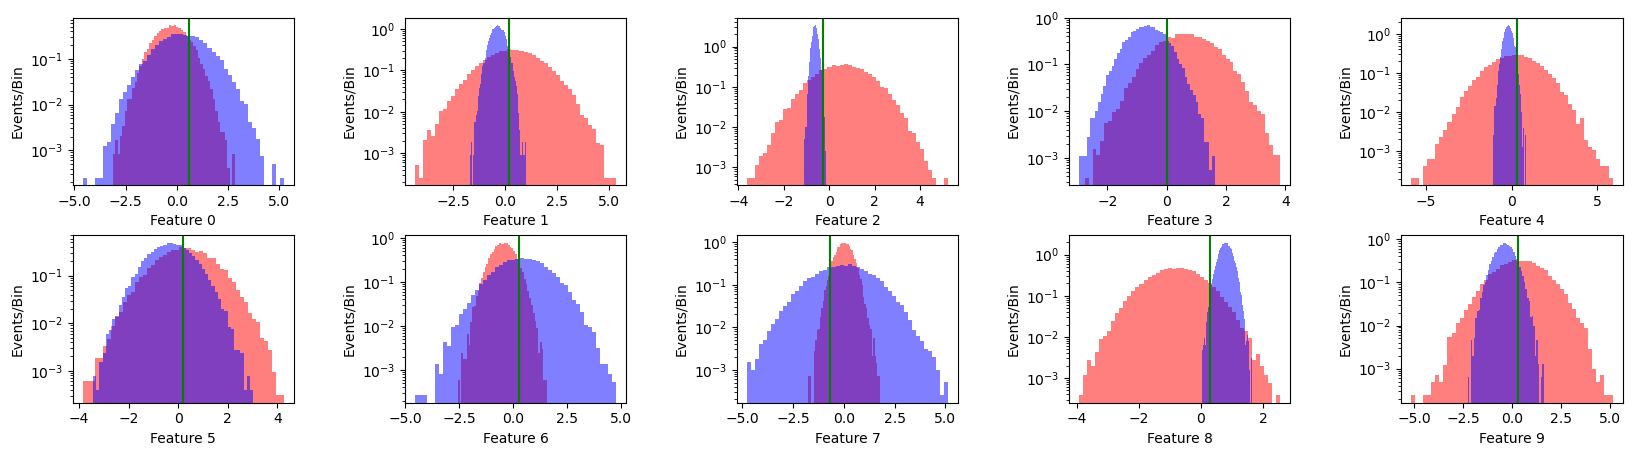

In [25]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net.bias.detach().numpy()
weights=net.weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = scaled_cuts[b], color='g')

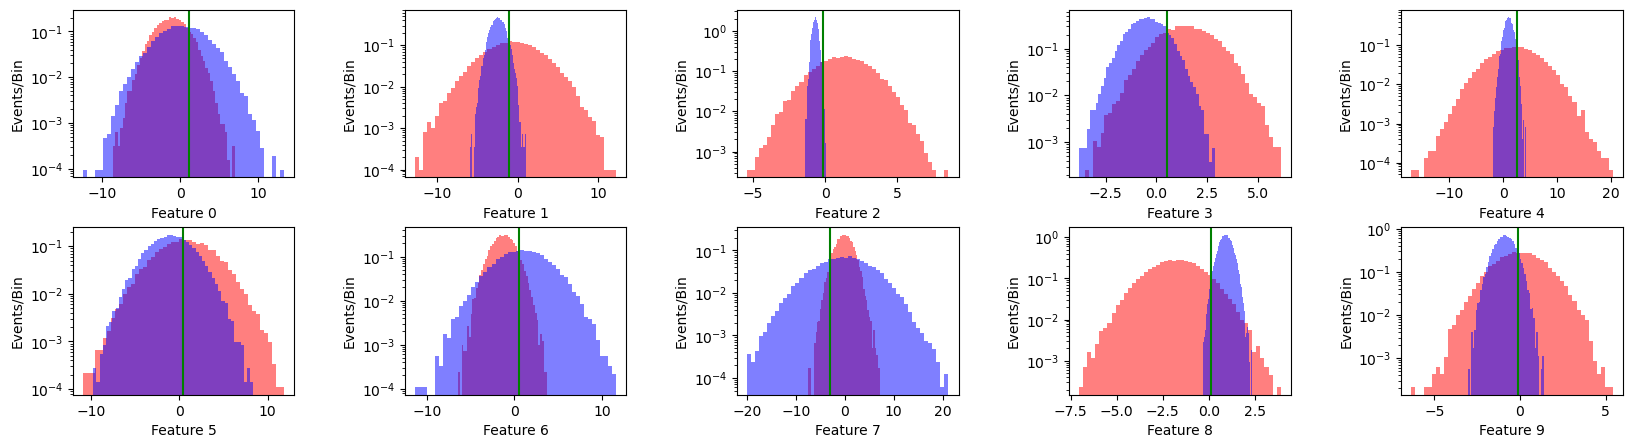

In [26]:
# Distributions before scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

cuts=sc.inverse_transform([scaled_cuts])[0]

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = cuts[b], color='g')

Now, what is this finding?  It's encoding the cut values in the weights and biases, but we need to evaluate the
efficiency of those cuts, not just the overall performance.

One tricky thing is whether these are "less than" cuts or "greater than" cuts.  The output of the network, prior to activation, should push background-like events to negative values, and signal-like events to positive values, such that the activation function maps them properly onto a zero-to-one range.  I think it's then enough to pass the event through the network and test if the values are less than or greater than zero.

Try a max(outputs) function, basically inf-norm.


In [27]:
total_test=len(y_test)

num_pass_test=0
test_outputs = net(x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
falses=torch.tensor(m*[False])
for i in range(len(test_outputs)):
    #for j in range(m):
    #    if scaled_cuts[j]<0:
    #        if x_test_tensor[i][j]
    tt=0.5+torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)
    if i==1:
        print(x_test[i])
        print(y_test[i])
        print(x_test_tensor[i])
        print(test_outputs[i])
        print(t)
    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    #elif torch.equal(t,falses) and y_test[i]==0.:
    #    num_pass_test+=1

effic_test = num_pass_test / total_test
print(effic_test)

[-2.54454249 -4.65963979  1.58261081  1.06084618  6.51575633  0.16097758
 -0.47642914 -1.62256609 -2.45512417  0.07704385]
1.0
tensor([-0.8169, -1.2308,  0.8251,  0.3656,  1.5537,  0.0960, -0.1293, -0.3438,
        -1.2086,  0.4481])
tensor([1.0000e+00, 3.0475e-09, 1.0000e+00, 9.8659e-01, 1.0000e+00, 2.5614e-01,
        9.9507e-01, 9.9438e-01, 1.0000e+00, 8.7776e-01])
tensor([ True, False,  True,  True,  True, False,  True,  True,  True,  True])
0.013875


This clearly isn't working very well.  I think the problem is that the BCE loss is not useful here, since it
relies on computing a single summary score for each event.  

# Modifying the Loss Function

This works now, with m=1 and m=2.

In [28]:
N=20000 # number of points
m=10 # dimensions

In [29]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

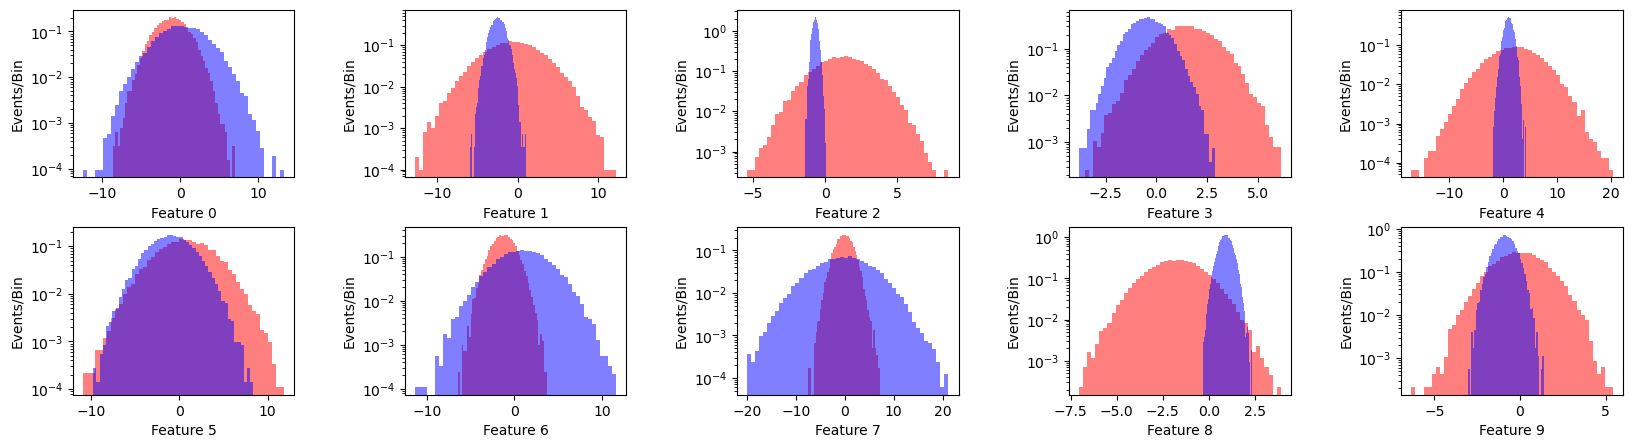

In [30]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [32]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [33]:
from LearningCutsUtils.LearningCutsUtils import loss_fn as loss_fn

In [34]:
torch.manual_seed(123)
activation_input_scale_factor=4.

In [35]:
net=OneToOneLinear(m,activation_input_scale_factor)
torch.save(net.state_dict(), 'net_learningcuts_2.pth')

In [36]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
batch_size=int(len(y_train)/1) # one batch
epochs=100
alpha=0.5   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8
{n: theta.shape for n, theta in net.named_parameters()}

{'weight': torch.Size([10]), 'bias': torch.Size([10])}

In [37]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningcuts_2.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m, net, target_efficiency, alpha, beta, gamma)
        (loss.totalloss()).backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss =loss_fn(y_pred, y_test_tensor, m, net, target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net.bias[0]
    weight=net.weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e} = {loss.efficloss:4.1e} + {loss.backgloss:4.1e} + {loss.cutszloss:4.1e}, Test loss={test_loss.totalloss().data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*loss.signaleffic:4.1f}%, bkg_eff={100*loss.backgreffic:6.3f}%")
    #cuts=net[0].bias/net[0].weight
    #print(cuts)

Completed epoch  0 in  0.6s, Train loss=3.2e-01 = 3.2e-01 + 4.6e-03 + 0.0e+00, Test loss=3.2e-01, cut=-4.4e-01, sig_eff= 0.2%, bkg_eff= 0.046%
Completed epoch  1 in  0.7s, Train loss=3.2e-01 = 3.2e-01 + 2.3e-04 + 5.5e-04, Test loss=3.2e-01, cut=-5.2e-01, sig_eff= 0.1%, bkg_eff= 0.002%
Completed epoch  2 in  0.6s, Train loss=3.2e-01 = 3.2e-01 + 4.6e-05 + 4.8e-04, Test loss=3.2e-01, cut=-5.2e-01, sig_eff= 0.0%, bkg_eff= 0.000%
Completed epoch  3 in  0.7s, Train loss=3.2e-01 = 3.2e-01 + 1.8e-05 + 3.5e-04, Test loss=3.2e-01, cut=-5.1e-01, sig_eff= 0.0%, bkg_eff= 0.000%
Completed epoch  4 in  0.8s, Train loss=3.2e-01 = 3.2e-01 + 9.8e-06 + 2.6e-04, Test loss=3.2e-01, cut=-4.8e-01, sig_eff= 0.0%, bkg_eff= 0.000%
Completed epoch  5 in  0.9s, Train loss=3.2e-01 = 3.2e-01 + 6.6e-06 + 2.2e-04, Test loss=3.2e-01, cut=-4.5e-01, sig_eff= 0.0%, bkg_eff= 0.000%
Completed epoch  6 in  0.7s, Train loss=3.2e-01 = 3.2e-01 + 5.1e-06 + 2.0e-04, Test loss=3.2e-01, cut=-4.1e-01, sig_eff= 0.0%, bkg_eff= 0.000%

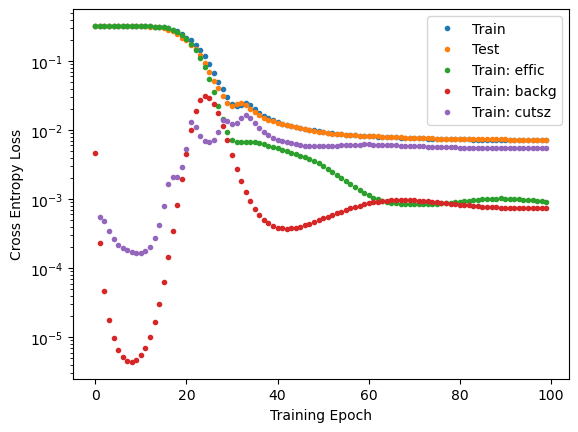

In [38]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

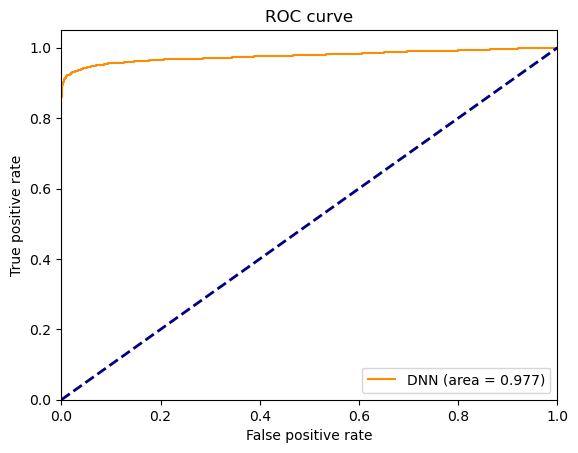

In [39]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.prod(net(x_test_tensor),dim=1).detach().cpu()
y_pred_train= torch.prod(net(x_train_tensor),dim=1).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

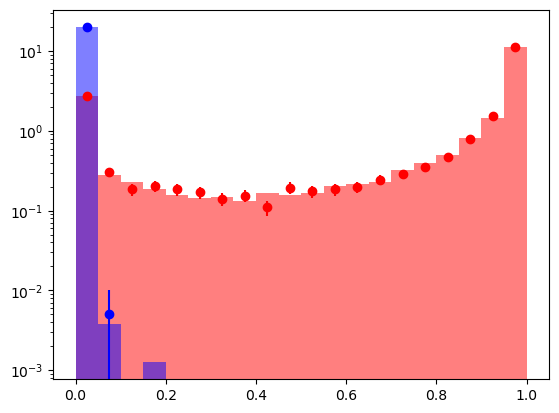

In [40]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

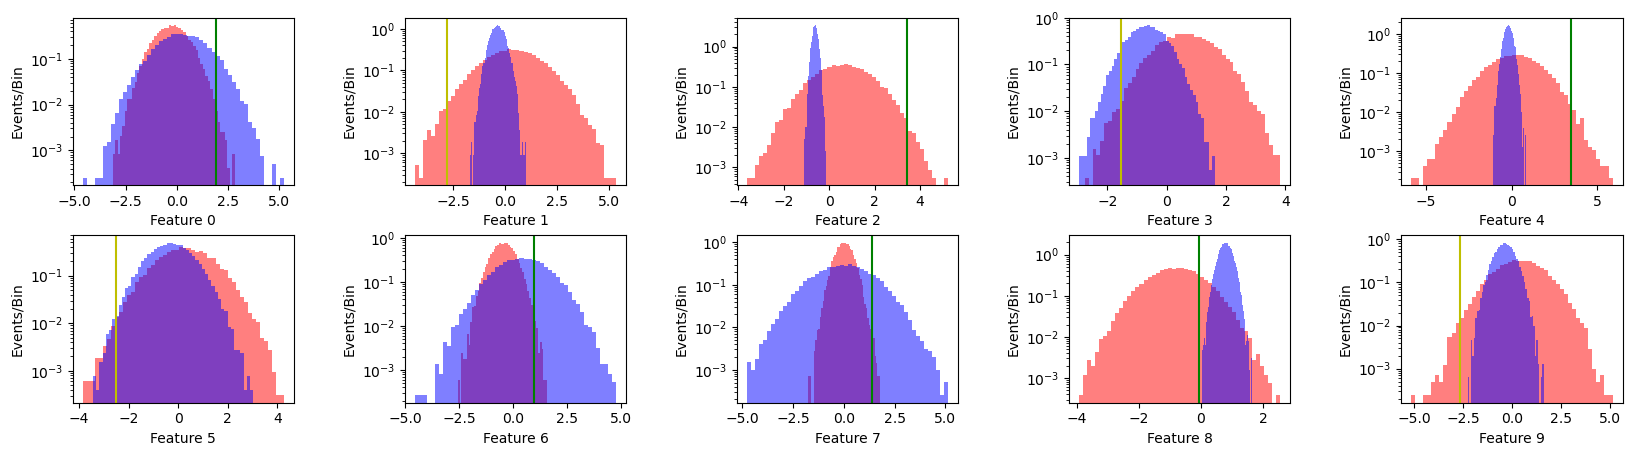

In [41]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net.bias.detach().numpy()
weights=net.weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

Apply the cuts on the network inputs.  This corresponds to requiring 

$$ y_i = w_ix_i + b_i > 0 $$

which implies:

$$ x_i > -\frac{b_i}{w_i} $$

We could apply the second criterion, but the first layer of the network already gives us the events that satisfy this condition!  We just need to pass the $x$ inputs through the first layer of the network.  If we pass into the first layer (without the activation function) then the test is $y>0$, if we pass through the full network (including the activation function) then the test is $y'>0.5$.  We'll save a few CPU cycles and just do the first layer of the network.

In [42]:
LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net,True)

Signal Efficiency with net outputs: 78.6%
Background Efficiency with net outputs: 0.00000%


Note that these efficiencies may be slightly different from what we see in the loss function, which 
computes a floating point number for each event, rather than incrementing an integer.  So a background event that only barely fails the cuts will contribute a little bit towards a non-zero background efficiency in the loss, while in this test it will contribute just as much as an event that fails all cuts badly (i.e. it will contribute nothing to the background efficiency).

# Efficiency scan

The next thing we can think about implementing is setting up an efficiency scan.  Vary the target efficiency and force
the cuts to vary gracefully.  We probably want to implement this as yet another loss function, and add the two losses together in an outer loop.  This means setting up separate networks for each target efficiency, passing the data into all of them to retrieve the losses, and then computing the total loss as the sum of the losses plus the penalty for having cuts that don't behave smoothly

First let's set up some infrastructure to handle multiple efficiency targets, but try to reproduce the results from before.

In [43]:
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn as effic_loss_fn

In [44]:
targeteffics=[0.8]

In [45]:
torch.manual_seed(123)
net = EfficiencyScanNetwork(m,targeteffics,weights=None,activationscale=activation_input_scale_factor) # will take m inputs, return m*n_eff outputs

{n: theta.shape for n, theta in net.named_parameters()}

{'nets.0.weight': torch.Size([10]), 'nets.0.bias': torch.Size([10])}

In [46]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
print(net.parameters())
batch_size=int(len(y_train)/1.) # one batch
epochs=100
alpha=0.5   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=0   # how much to penalize deviations

<generator object Module.parameters at 0x7fb932139ee0>


In [47]:
losses = []
losses_test = []

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.9s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  1 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  2 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  3 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  4 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  5 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  6 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  7 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  8 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  9 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 10 in  0.5s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 11 in  0.7s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 12 in  0.6s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 13 in  0.7s, Train loss=3.2e-01, Test loss=3.1e-01
Completed epoch 14 in  0.7s, Train loss=3.1e-01, Test loss=3.1

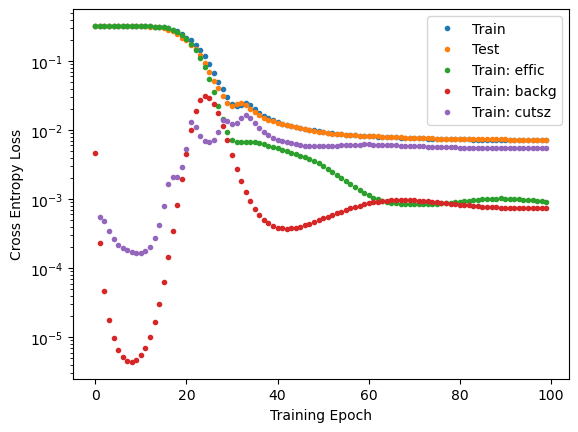

In [48]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

Target efficiency: 80.0%
Cuts are: [ 1.906048   -2.8051581   3.4189644  -1.5396518   3.50561    -2.5211046
  0.97923845  1.406305   -0.04957386 -2.6859815 ]


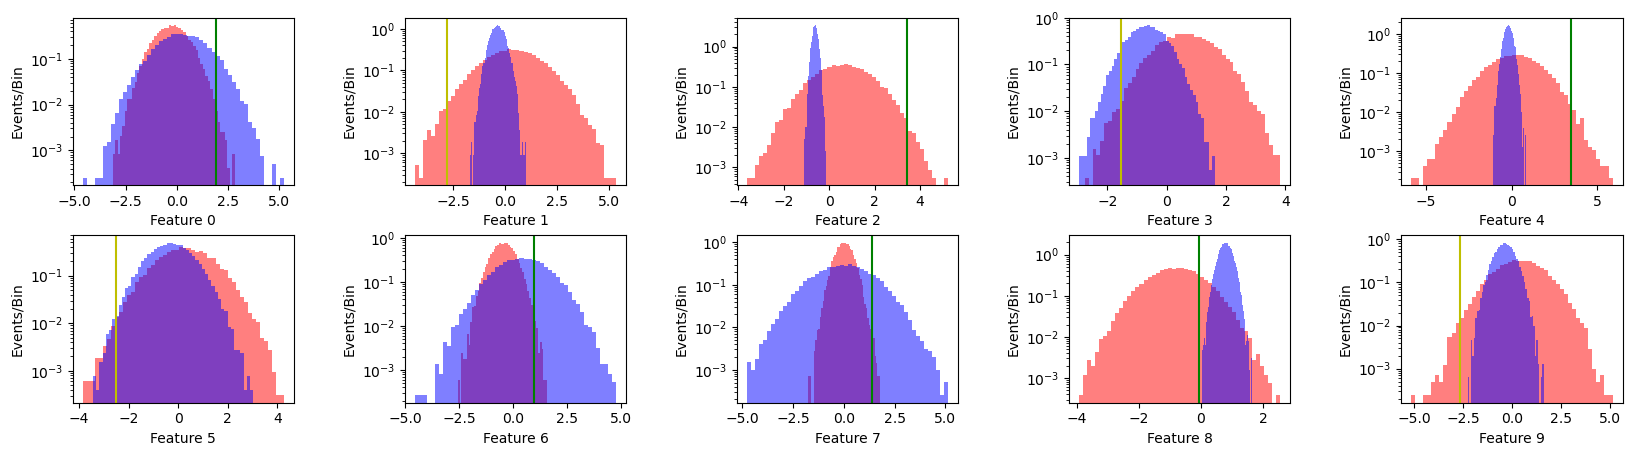

In [49]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

In [50]:
LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[0],True)

Signal Efficiency with net outputs: 78.6%
Background Efficiency with net outputs: 0.00000%


## Multiple efficiency targets

Now let's test a few different efficiency targets and see how it learns.

This technique is sensitive to getting stuck in local minima, benefits from minibatch training to not get trapped.

In [51]:
targeteffics=[0.6,0.7,0.8,0.9]
torch.manual_seed(123)
net = EfficiencyScanNetwork(m,targeteffics,None,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
print({n: theta.shape for n, theta in net.named_parameters()})

# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
print(net.parameters())
nbatches=10
batch_size=int(len(y_train)/nbatches)
epochs=100
alpha=1.     # scaling factor to tune how important hitting the target signal efficiency is
beta=5.      # scaling factor to tune how important background rejection is
gamma=1e-3   # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2 # how much to penalize deviations of cuts for adjacent target efficiencies

losses = []
losses_test = []

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False
if debug:
    epochs=20

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        if debug:
            print(-net.nets[0].bias/net.nets[0].weight)
            print(-net.nets[1].bias/net.nets[1].weight)
        loss.totalloss().backward()
        if debug:
            print(net.nets[0].bias)
            print(net.nets[1].bias)
            print(net.nets[0].weight)
            print(net.nets[1].weight)
            getBack(loss.grad_fn)
            #print(-net.nets[0].bias/net.nets[0].weight)
            #print(-net.nets[1].bias/net.nets[1].weight)
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

{'nets.0.weight': torch.Size([10]), 'nets.0.bias': torch.Size([10]), 'nets.1.weight': torch.Size([10]), 'nets.1.bias': torch.Size([10]), 'nets.2.weight': torch.Size([10]), 'nets.2.bias': torch.Size([10]), 'nets.3.weight': torch.Size([10]), 'nets.3.bias': torch.Size([10])}
<generator object Module.parameters at 0x7fb924062a40>
Completed epoch  0 in  0.9s, Train loss=1.8e+00, Test loss=1.8e+00
Completed epoch  1 in  0.8s, Train loss=1.1e+00, Test loss=1.1e+00
Completed epoch  2 in  0.6s, Train loss=5.1e-01, Test loss=4.7e-01
Completed epoch  3 in  0.8s, Train loss=3.2e-01, Test loss=3.1e-01
Completed epoch  4 in  0.6s, Train loss=2.7e-01, Test loss=2.7e-01
Completed epoch  5 in  0.8s, Train loss=2.3e-01, Test loss=2.3e-01
Completed epoch  6 in  0.7s, Train loss=1.9e-01, Test loss=1.9e-01
Completed epoch  7 in  0.6s, Train loss=1.7e-01, Test loss=1.6e-01
Completed epoch  8 in  0.7s, Train loss=1.4e-01, Test loss=1.4e-01
Completed epoch  9 in  0.6s, Train loss=1.3e-01, Test loss=1.2e-01
Co

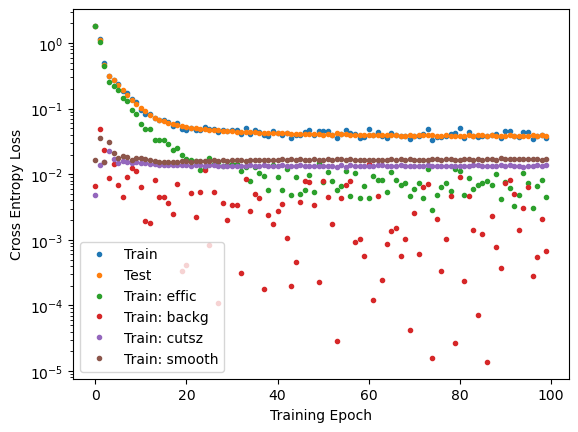

In [52]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [53]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[n],True)

Target efficiency: 60.0%
Signal Efficiency with net outputs: 59.7%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 69.5%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 77.9%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 82.9%
Background Efficiency with net outputs: 0.02509%


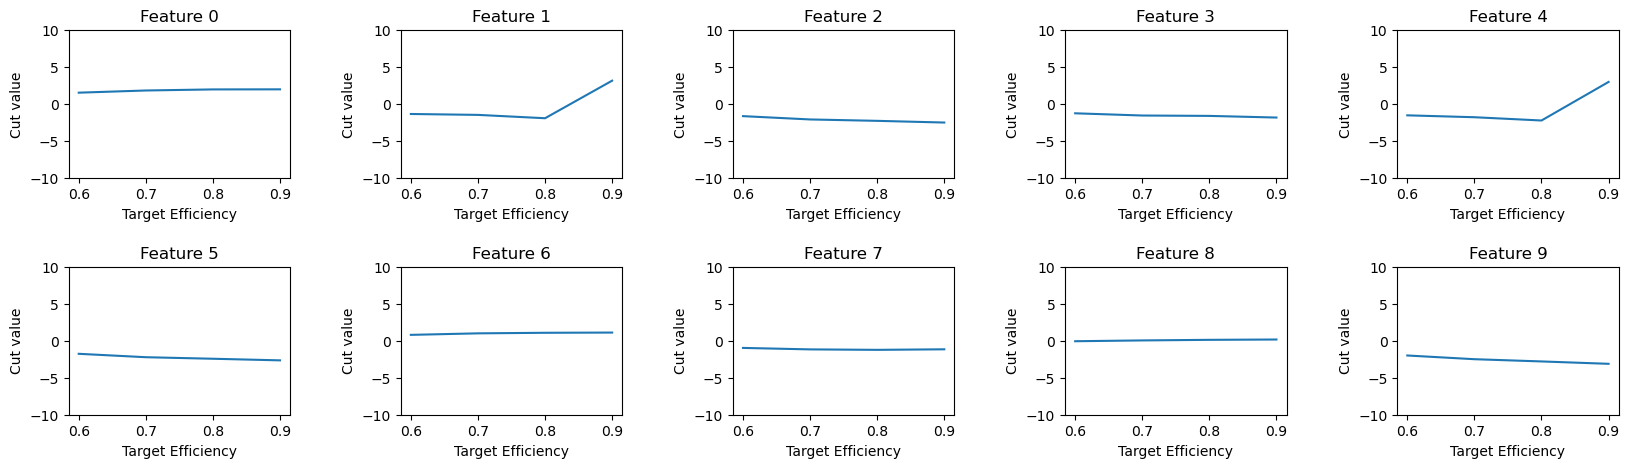

In [54]:
LearningCutsUtils.LearningCutsUtils.plotcuts(net)

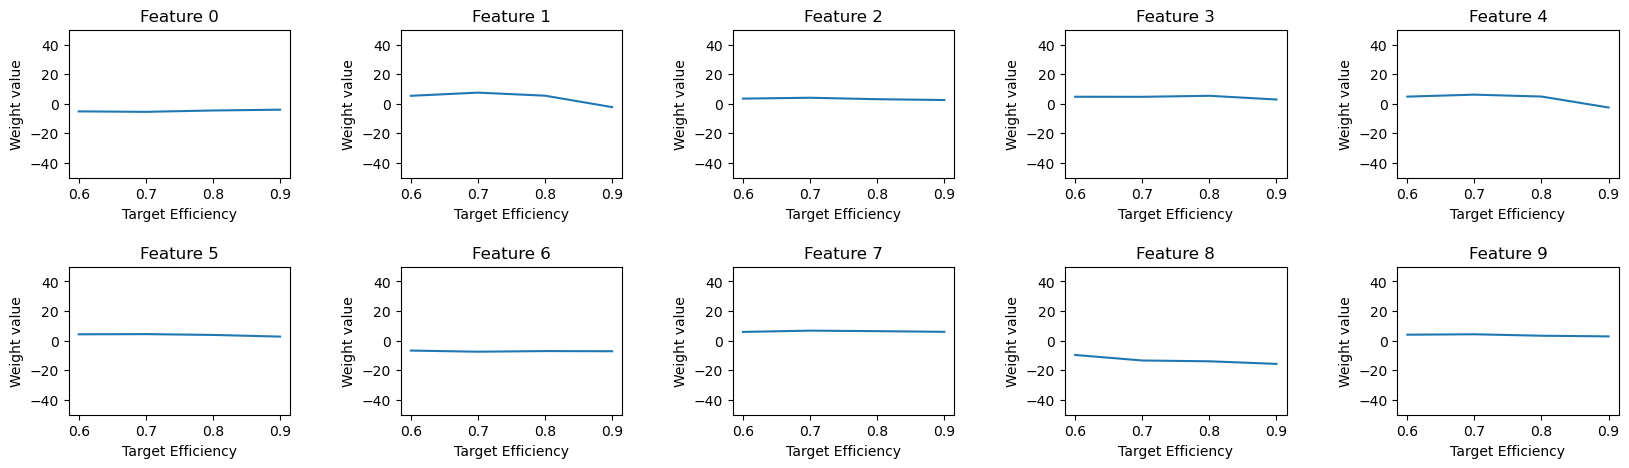

In [55]:
# Distributions of weights
fig = plt.figure(figsize=(20,5))
fig.tight_layout()

weights=[len(targeteffics)*[0] for i in range(m)]
for n in range(len(targeteffics)):
    nweights=net.nets[n].weight.detach().numpy()
    for f in range(m):
        w=nweights[f]
        weights[f][n]=w
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,weights[b])
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel("Weight value")
    ax.set_title(f"Feature {b}")
    ax.set_ylim([-50,50])

Target efficiency: 60.0%
Cuts are: [ 1.4975452  -1.3809295  -1.671852   -1.2889408  -1.5636919  -1.7724192
  0.7870665  -0.9772151  -0.07320575 -1.9996376 ]


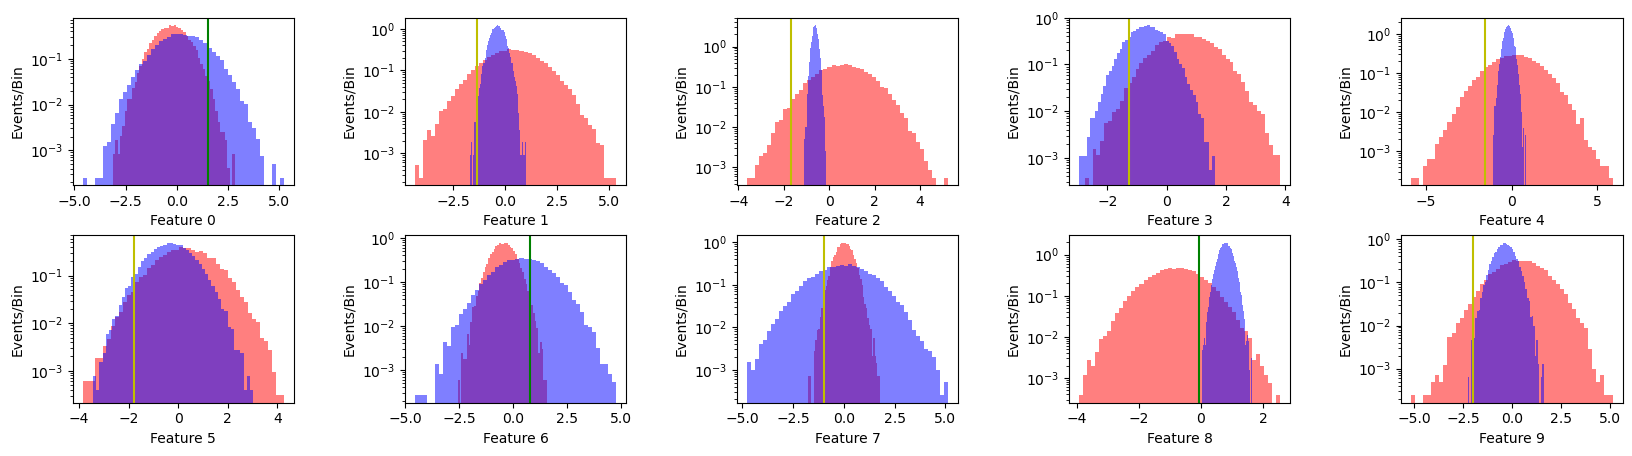

Target efficiency: 70.0%
Cuts are: [ 1.7921811  -1.5030626  -2.119451   -1.5878727  -1.8187951  -2.2320697
  0.9908923  -1.1758786   0.03502053 -2.5009267 ]


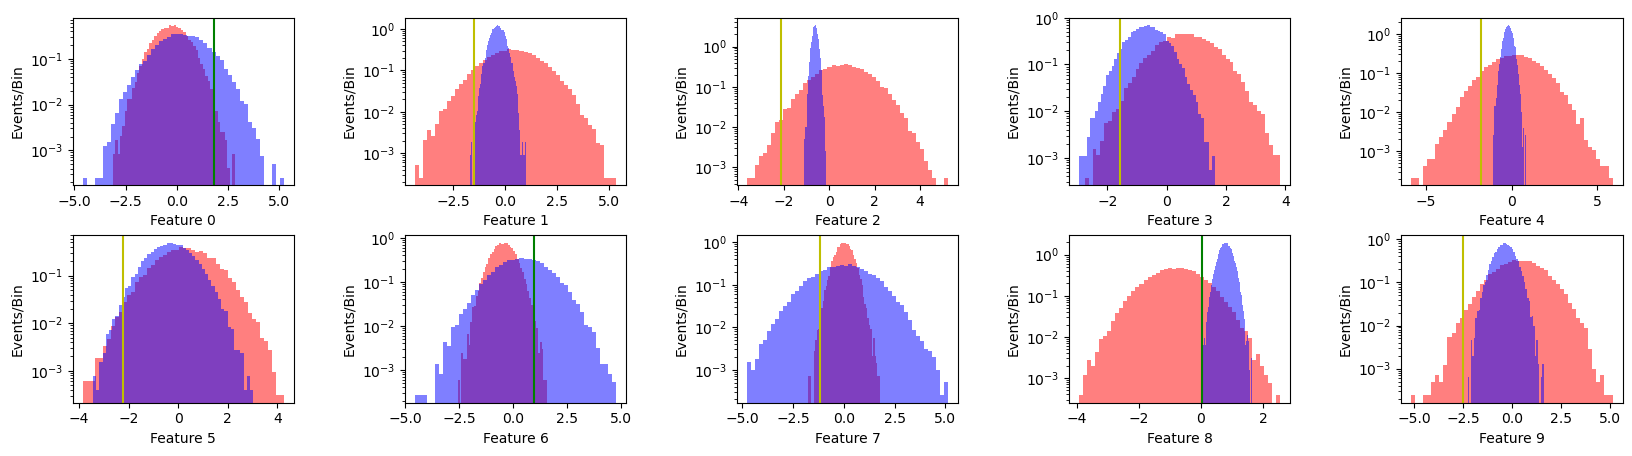

Target efficiency: 80.0%
Cuts are: [ 1.9375138  -1.954379   -2.3077466  -1.6390479  -2.2609646  -2.440245
  1.066468   -1.2377219   0.11451299 -2.80265   ]


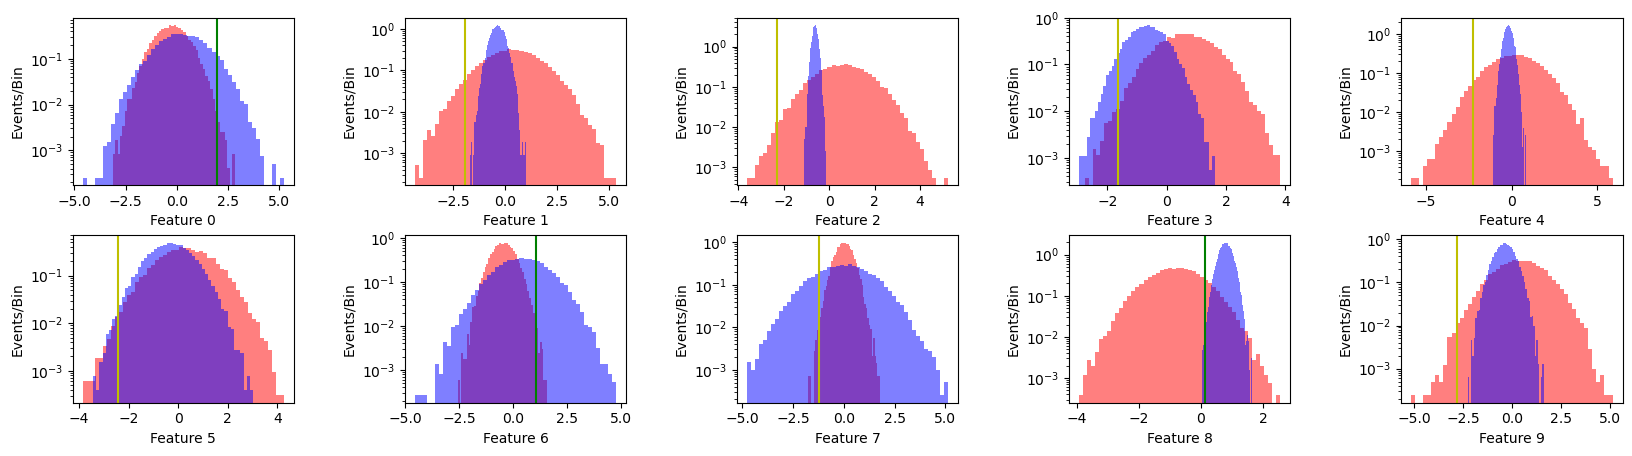

Target efficiency: 90.0%
Cuts are: [ 1.9479709   3.1202855  -2.5361674  -1.861928    2.948789   -2.6571734
  1.0965507  -1.1643413   0.15851969 -3.1241763 ]


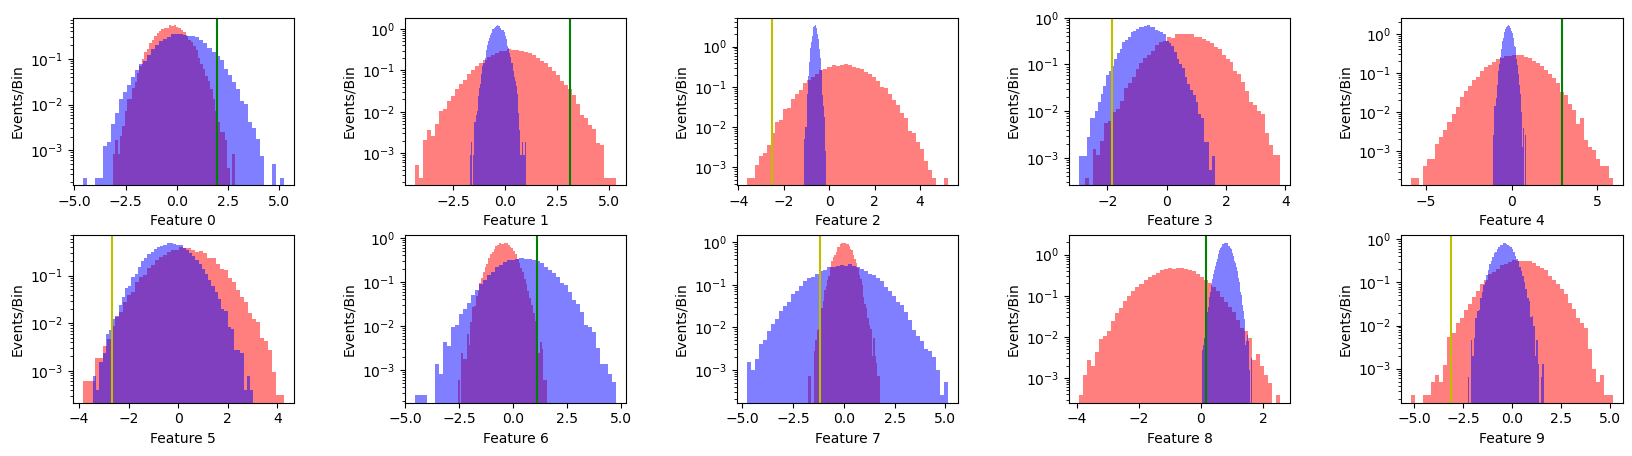

In [56]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

This isn't quite working yet, but getting closer.

To do:
* We need to analyze all the small contributions to the total loss.  Pull them out of the summary distributions and make them available to inspect as training happens.
* Change the scan to fix the weights to +/- 1, and then just have the network learn the biases.  Then we have a straightforward interpretation of "less than" vs "greater than" cuts, and we don't force the network to scan a 2D space.  This should speed up learning, make it more robust, at the cost of forcing the user to specify whether they want a "greater than" or "less than" cut a priori.  That seems like a reasonable compromise.  
   * I think if we want to allow both "greater than" and "less than" cuts, we can just pass the same distribution in as an duplicate input, but fix the weight for the duplicate to have a different sign.
* Split this notebook up into separate examples.